In [1]:
import PyPDF2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')
from transcript_functions import *

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rawin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rawin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
import pdftotext

df = pd.DataFrame(columns = ['raw_text','year'])

for k in range(10,20):
    
    pdfFileObj = open("C:/Users/rawin/Documents/GitHub/Capstone-Project/Proxies/Kroger/20%s_proxy.pdf"%(k),'rb')
    pdf = pdftotext.PDF(pdfFileObj)
    
    year = "20%s"%(k)
    company = "Kroger"

    sub_df = pd.DataFrame(columns = ['raw_text','year'])
    for page in pdf:
        x = page.replace('\n \n',', ')
        x = page.replace('\n',' ')
        sub_df = sub_df.append({'raw_text':x,'year':year,'company':company},ignore_index=True)

    df = pd.concat([df,sub_df],ignore_index=True)

In [3]:
df.shape

(1290, 3)

In [4]:
#remove numbers
df['raw_text'] =  df['raw_text'].map(lambda x: re.sub(r'\d+', '', x))

stop_words = set(stopwords.words('english'))

punctuations = ['(',')',';',':','[',']',',','.',"''",'$','%','``',"’",".//","”",'-','˜˜','@','?','...']

#tokenize, lower-case, remove stopwords, and remove punctuations
df["tokens_clean"] = df["raw_text"].map(lambda x: [word.lower() for word in word_tokenize(x) 
                                                   if word not in stop_words and word not in punctuations])

In [5]:
# tag Part of Speech
df["tokens_pos"] = df["tokens_clean"].map(nltk.pos_tag)
# filter words with pos not in pos_keep
pos_keep = ["NN", "NNS","VB", "VBD", "VBN", "VBP", "VBZ"] #take out "JJ", "JJR", "JJS"
df["tokens_pos"] = df["tokens_pos"].map(lambda x: [tup for tup in x if tup[1] in pos_keep])

# lemmatize with POS
lemmatizer = WordNetLemmatizer()
df["tokens_final"] = df["tokens_pos"].map(lambda x: [lemmatizer.lemmatize(tup[0], get_wordnet_pos(tup[1])) for tup in x ])

df["tokens_final"] = df["tokens_final"].map(lambda x: [word for word in x if len(word)>3])


In [6]:
remove_words =['shareholders','board','mr.','director','committee','proxy','meeting','share',
               'vote','shareholder','stock','plan','compensation']

df["tokens_final"] = df["tokens_final"].map(lambda x: [word for word in x if word.lower() not in remove_words])

In [7]:
#keeping only rows that has more than 3 elements in tokens_final
df = df[df['tokens_final'].apply(lambda x: len(x) > 5)]

In [8]:
kroger_df = df[['year','company','tokens_final']]

kroger_df.to_csv(path_or_buf ='C:\\Users\\rawin\\Documents\\GitHub\\Capstone-Project\\Proxies\\All\\kroger.csv', index = False)

In [9]:
import gensim
from gensim.utils import simple_preprocess
from gensim.test.utils import common_corpus, common_dictionary

import pprint
pp = pprint.PrettyPrinter(indent=4)

In [10]:
dictionary = gensim.corpora.Dictionary(df["tokens_final"])

dictionary.filter_extremes(no_below=1, no_above=0.5) #, keep_n=100000)

bow_corpus = [dictionary.doc2bow(word) for word in df["tokens_final"]]

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=15, id2word=dictionary, 
                                       passes=2, workers=2, chunksize=100, random_state=1000)

In [11]:
pp.pprint(lda_model.print_topics())

[   (   0,
        '0.072*"award" + 0.037*"participant" + 0.035*"option" + '
        '0.030*"performance" + 0.028*"grant" + 0.025*"unit" + 0.020*"section" '
        '+ 0.020*"time" + 0.018*"cash" + 0.017*"term"'),
    (   1,
        '0.034*"sale" + 0.026*"customer" + 0.022*"fuel" + 0.021*"increase" + '
        '0.019*"supermarket" + 0.015*"program" + 0.015*"goal" + 0.013*"result" '
        '+ 0.013*"performance" + 0.013*"growth"'),
    (   2,
        '0.025*"interest" + 0.024*"asset" + 0.020*"rate" + 0.018*"liability" + '
        '0.018*"loss" + 0.017*"income" + 0.016*"cash" + 0.016*"cost" + '
        '0.014*"estimate" + 0.013*"balance"'),
    (   3,
        '0.027*"proposal" + 0.025*"hereof" + 0.018*"regulation" + '
        '0.017*"material" + 0.016*"person" + 0.015*"time" + 0.013*"rule" + '
        '0.012*"performance" + 0.012*"election" + 0.012*"date"'),
    (   4,
        '0.021*"chairman" + 0.020*"governance" + 0.019*"serve" + '
        '0.018*"management" + 0.017*"risk" + 0.017*"

In [12]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)

In [13]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.231860 -0.033978       1        1  11.630824
5      0.024816  0.222640       2        1  11.120811
13    -0.037346 -0.117372       3        1  10.864929
2      0.029645  0.166530       4        1  10.474921
14    -0.070034  0.205320       5        1   9.031587
4     -0.161631 -0.178008       6        1   8.873592
1     -0.125853  0.084737       7        1   8.435284
3      0.079612 -0.183459       8        1   5.673645
7     -0.037596  0.029083       9        1   4.935456
9      0.085366  0.127990      10        1   3.857802
11    -0.093274 -0.073229      11        1   3.264465
10     0.006620  0.069451      12        1   3.249911
6     -0.290512 -0.086336      13        1   3.164980
8      0.098957 -0.138609      14        1   2.826346
12     0.259370 -0.094760      15        1   2.595463, topic_info=             Term         Freq        Total Category  logprob  loglift
280         award  1887.000000  1887.000000  Default  30.0000  30.0000
27         person   742.000000   742.000000  Default  29.0000  29.0000
267       pension  1385.000000  1385.000000  Default  28.0000  28.0000
613        option  1374.000000  1374.000000  Default  27.0000  27.0000
1693    packaging   591.000000   591.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
472    regulation    42.652248   450.473419  Topic15  -4.7130   1.2942
28          price    46.294300   718.970154  Topic15  -4.6311   0.9086
43           unit    48.661518   995.661316  Topic15  -4.5812   0.6329
93    performance    47.232700  1730.488525  Topic15  -4.6110   0.0503
239          time    43.315655  1049.438721  Topic15  -4.6976   0.4639

[1032 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
486       2  0.122491            ability
486       3  0.142906            ability
486       4  0.010208            ability
486       5  0.005104            ability
486       6  0.153113            ability
...     ...       ...                ...
2567      8  0.922582  www.proxyvote.com
2258      6  0.151387        www.sec.gov
2258     11  0.832628        www.sec.gov
1579      2  0.910413        zero-coupon
2538     15  0.665879               zone

[4362 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 14, 3, 15, 5, 2, 4, 8, 10, 12, 11, 7, 9, 13])

In [14]:
df.columns

Index(['raw_text', 'year', 'company', 'tokens_clean', 'tokens_pos',
       'tokens_final'],
      dtype='object')

## Finding the dominant topic in each page

In [15]:
def format_topics_pages(ldamodel=lda_model, corpus=bow_corpus, texts=df[['year','tokens_final']]):
    # Init output
    page_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                page_topics_df = page_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    page_topics_df.columns = ['topic', 'perc_contribution', 'topic_keywords']

    # Add original text to the end of the output
    page_topics_df = pd.concat([texts,page_topics_df], axis=1)
    return(page_topics_df)


df_topic_pages_keywords = format_topics_pages(ldamodel=lda_model, corpus=bow_corpus, texts=df[['year','tokens_final']])

# Format
df_dominant_topic = df_topic_pages_keywords.reset_index()
df_dominant_topic = df_dominant_topic.drop('index',axis=1)

# Show
df_dominant_topic.head(10)

,year,tokens_final,topic,perc_contribution,topic_keywords
0,2010,"[section, statement, schedule, rule, informati...",3.0,0.9003,"proposal, hereof, regulation, material, person..."
1,NaN,NaN,1.0,0.7614,"sale, customer, fuel, increase, supermarket, p..."
2,NaN,NaN,1.0,0.9018,"sale, customer, fuel, increase, supermarket, p..."
3,2010,"[kroger, team, deliver, result, position, adva...",1.0,0.6730,"sale, customer, fuel, increase, supermarket, p..."
4,2010,"[sale, kroger, grow, sale, objective, business...",7.0,0.9369,"cost, obligation, change, affect, result, cont..."
5,2010,"[commit, safety, safety, core, value, kroger, ...",4.0,0.6139,"chairman, governance, serve, management, risk,..."
6,2010,"[challenge, look, pace, recovery, continue, in...",3.0,0.9515,"proposal, hereof, regulation, material, person..."
7,2010,"[congratulation, winners, kroger, community, s...",3.0,0.9918,"proposal, hereof, regulation, material, person..."
8,2010,"[cincinnati, ohio, hold, energy, convention, c...",3.0,0.6117,"proposal, hereof, regulation, material, person..."
9,2010,"[cincinnati, ohio, solicit, cost, solicitation...",4.0,0.8836,"chairman, governance, serve, management, risk,..."


In [16]:
df_dominant_topic.shape

(1288, 5)

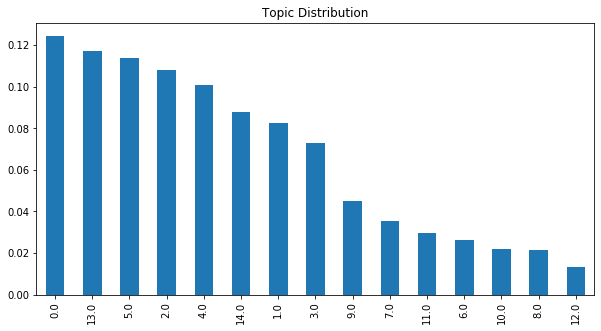

In [17]:
topic_counts = df_dominant_topic["topic"].value_counts()
(topic_counts/topic_counts.sum()).plot(x="Topics", y="Percentage",
                                       title="Topic Distribution",
                                       kind="bar", figsize=(10,5))

## Topic Trends

In [18]:
df_trend = pd.crosstab(df_dominant_topic["year"], df_dominant_topic["topic"], normalize="index")
years = [str(x) for x in df_trend.index]

In [19]:
df_trend

topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
year,,,,,,,,,,,,,,,
2010,0.054795,0.061644,0.136986,0.075342,0.082192,0.123288,0.020548,0.061644,0.027397,0.047945,0.027397,0.034247,0.020548,0.095890,0.130137
2011,0.121019,0.076433,0.121019,0.050955,0.089172,0.101911,0.019108,0.057325,0.019108,0.063694,0.038217,0.025478,0.031847,0.108280,0.076433
2012,0.046875,0.085938,0.117188,0.062500,0.093750,0.140625,0.023438,0.046875,0.023438,0.054688,0.031250,0.031250,0.000000,0.148438,0.093750
2013,0.079710,0.079710,0.108696,0.065217,0.094203,0.152174,0.043478,0.043478,0.028986,0.043478,0.021739,0.021739,0.007246,0.115942,0.094203
2014,0.200000,0.045161,0.103226,0.045161,0.083871,0.141935,0.019355,0.038710,0.025806,0.032258,0.025806,0.032258,0.012903,0.083871,0.109677
2015,0.127660,0.106383,0.127660,0.056738,0.113475,0.127660,0.028369,0.021277,0.007092,0.042553,0.014184,0.028369,0.000000,0.092199,0.106383
2016,0.104167,0.104167,0.152778,0.090278,0.090278,0.125000,0.020833,0.020833,0.006944,0.034722,0.027778,0.027778,0.000000,0.097222,0.097222
2017,0.203125,0.109375,0.000000,0.093750,0.218750,0.031250,0.031250,0.000000,0.015625,0.015625,0.000000,0.046875,0.015625,0.203125,0.015625
2018,0.324324,0.054054,0.000000,0.175676,0.148649,0.013514,0.013514,0.000000,0.027027,0.013514,0.000000,0.040541,0.040541,0.135135,0.013514


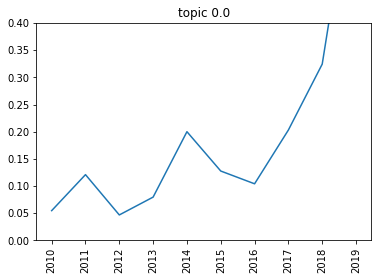

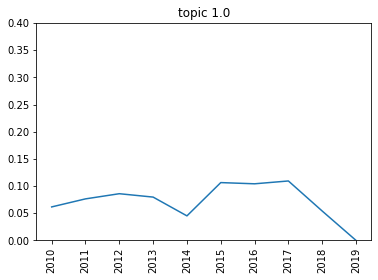

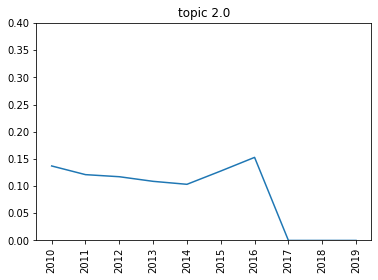

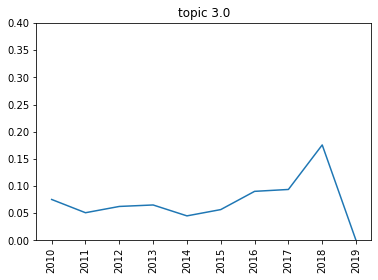

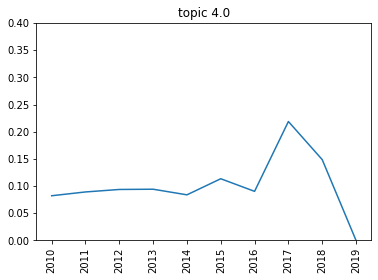

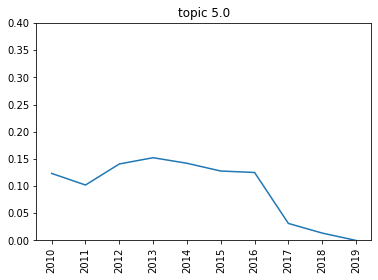

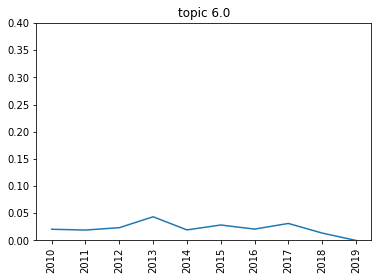

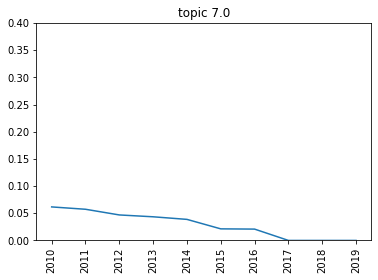

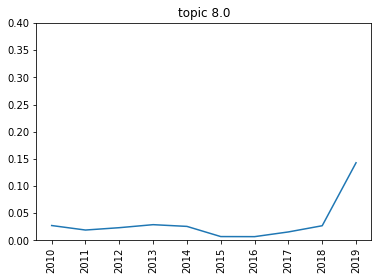

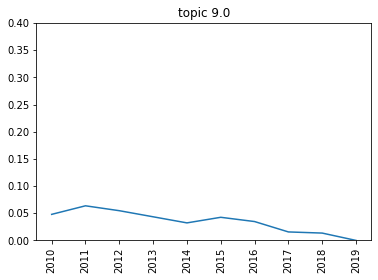

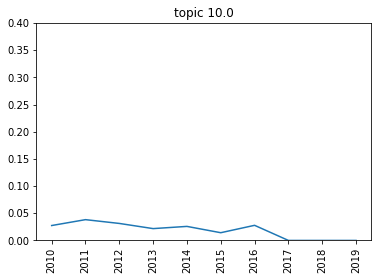

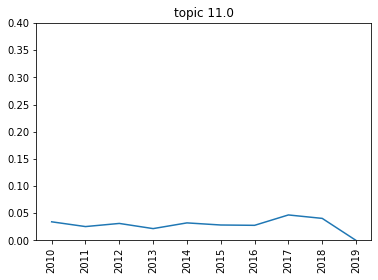

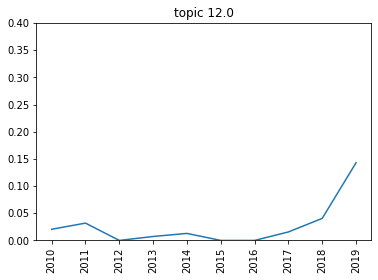

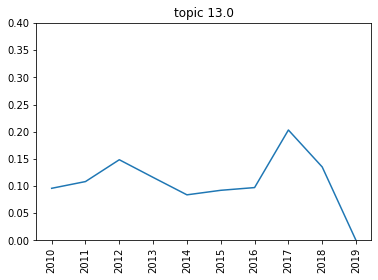

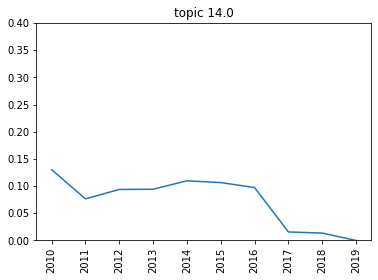

In [20]:
for topic in df_trend:
    fig, ax = plt.subplots()
    plt.plot(years, df_trend[topic].values)
    plt.ylim(0, 0.4)
    plt.xticks(years, years, rotation='vertical')
    plt.title("topic "+ str(topic))